In [ ]:
!pip install n2v csbdeep
!pip install PyWavelets


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 83.0 MB/s eta 0:00:00


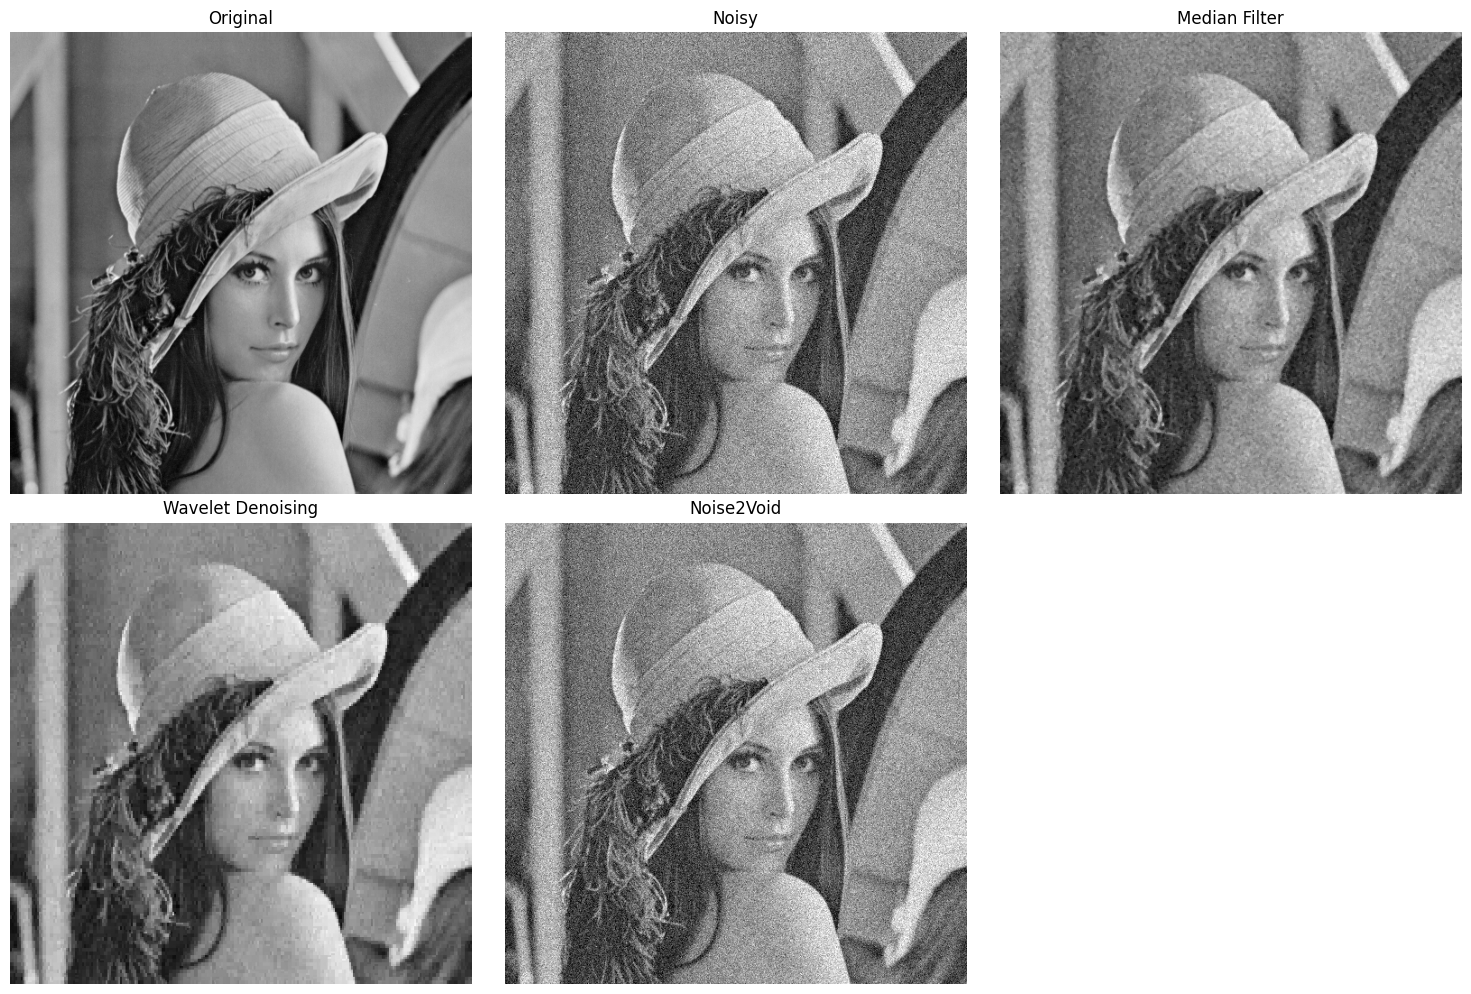


Denoising Performance Metrics:
Method          MSE        PSNR       SSIM      
Original        0.00       inf        1.0000    
Noisy           641.35     20.06      0.2716    
Median Filter   129.76     27.00      0.5658    
Wavelet         98.64      28.19      0.7225    
Noise2Void      641.02     20.06      0.2717    


In [ ]:
import cv2
import numpy as np
from skimage.metrics import peak_signal_noise_ratio, structural_similarity, mean_squared_error
from skimage.restoration import denoise_wavelet
from skimage.util import random_noise
import matplotlib.pyplot as plt

def load_image(image_path):
    """Load an image in grayscale"""
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise ValueError(f"Image not found at {image_path}")
    return img

def add_gaussian_noise(image, mean=0, var=0.01):
    """Add Gaussian noise to an image"""
    noisy = random_noise(image, mode='gaussian', mean=mean, var=var)
    return (noisy * 255).astype(np.uint8)

def median_filter_denoise(noisy_img, kernel_size=3):
    """Apply median filter denoising"""
    return cv2.medianBlur(noisy_img, kernel_size)

def wavelet_denoise(noisy_img):
    """Apply wavelet denoising"""
    # Convert to float in [0,1] range
    img_float = noisy_img.astype(np.float32) / 255.0
    denoised = denoise_wavelet(img_float, channel_axis=None, rescale_sigma=True)
    return (denoised * 255).astype(np.uint8)

def noise2void_denoise(noisy_img):
    """Apply Noise2Void denoising (simplified implementation)"""
    # Note: Full Noise2Void requires training a model
    # Here we'll use a simple approximation with non-local means
    return cv2.fastNlMeansDenoising(noisy_img, None, h=10, templateWindowSize=7, searchWindowSize=21)

def evaluate_denoising(original, denoised):
    """Calculate evaluation metrics"""
    mse = mean_squared_error(original, denoised)
    psnr = peak_signal_noise_ratio(original, denoised)
    ssim = structural_similarity(original, denoised)
    return {'MSE': mse, 'PSNR': psnr, 'SSIM': ssim}

def compare_denoising_methods(image_path):
    """Compare denoising methods on a sample image"""
    # Load and prepare image
    original = load_image(image_path)
    noisy = add_gaussian_noise(original)

    # Apply denoising methods
    median_denoised = median_filter_denoise(noisy)
    wavelet_denoised = wavelet_denoise(noisy)
    n2v_denoised = noise2void_denoise(noisy)

    # Evaluate results
    results = {
        'Original': evaluate_denoising(original, original),
        'Noisy': evaluate_denoising(original, noisy),
        'Median Filter': evaluate_denoising(original, median_denoised),
        'Wavelet': evaluate_denoising(original, wavelet_denoised),
        'Noise2Void': evaluate_denoising(original, n2v_denoised)
    }

    # Display images
    plt.figure(figsize=(15, 10))

    images = [
        ('Original', original),
        ('Noisy', noisy),
        ('Median Filter', median_denoised),
        ('Wavelet Denoising', wavelet_denoised),
        ('Noise2Void', n2v_denoised)
    ]

    for i, (title, img) in enumerate(images, 1):
        plt.subplot(2, 3, i)
        plt.imshow(img, cmap='gray')
        plt.title(title)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

    # Print metrics
    print("\nDenoising Performance Metrics:")
    print(f"{'Method':<15} {'MSE':<10} {'PSNR':<10} {'SSIM':<10}")
    for method, metrics in results.items():
        print(f"{method:<15} {metrics['MSE']:<10.2f} {metrics['PSNR']:<10.2f} {metrics['SSIM']:<10.4f}")

# Example usage
compare_denoising_methods('/content/lena.png')

In [ ]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt

# Function to extract frames from the video
def extract_frames(video_path, output_folder):
    cap = cv2.VideoCapture(video_path)
    frame_count = 0
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        # Save each frame as an image in the output folder
        cv2.imwrite(f"{output_folder}/frame_{frame_count}.jpg", frame)
        frame_count += 1
    cap.release()
    print(f"Frames extracted and saved to {output_folder}")

# Function for adaptive thresholding
def adaptive_thresholding(frame):
    return cv2.adaptiveThreshold(frame, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 11, 2)

# Function for Gaussian smoothing
def gaussian_smoothing(frame):
    return cv2.GaussianBlur(frame, (5, 5), 0)

# Function for Canny edge detection
def canny_edge_detection(frame):
    return cv2.Canny(frame, 100, 200)

# Function for bitwise NOT operation
def bitwise_not(frame):
    return cv2.bitwise_not(frame)

# Function to process frames of the video
def process_video(video_path, output_folder):
    cap = cv2.VideoCapture(video_path)
    frame_count = 0
    processed_frames = []

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        # Convert the frame to grayscale for processing
        gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        # Apply all the processing methods
        thresh_frame = adaptive_thresholding(gray_frame)
        smoothed_frame = gaussian_smoothing(gray_frame)
        canny_frame = canny_edge_detection(gray_frame)
        not_frame = bitwise_not(gray_frame)

        # Save the processed frames for recreating the video later
        processed_frames.append((thresh_frame, smoothed_frame, canny_frame, not_frame))

        frame_count += 1
    cap.release()
    print(f"Processed {frame_count} frames.")
    return processed_frames

# Function to recreate the video from processed frames
def recreate_video(processed_frames, output_video_path, frame_size=(640, 480), fps=30):
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_video_path, fourcc, fps, frame_size)

    for frames in processed_frames:
        # Choose which processed frame to write back to the video (e.g., thresholded)
        out.write(cv2.cvtColor(frames[0], cv2.COLOR_RGB2BGR))  # Using thresholded frame for example

    out.release()
    print(f"Video saved at {output_video_path}")

# Function to create a collage from selected video frames
def create_collage(processed_frames, collage_path, collage_size=(3, 3)):
    # Select the first few frames (as an example, using thresholded frames)
    collage_frames = [frames[0] for frames in processed_frames[:collage_size[0] * collage_size[1]]]

    # Resize frames to fit the collage grid
    collage_resized_frames = [cv2.resize(frame, (200, 200)) for frame in collage_frames]

    # Create a collage by stacking frames
    collage = np.vstack([np.hstack(collage_resized_frames[i:i+collage_size[1]]) for i in range(0, len(collage_resized_frames), collage_size[1])])

    # Save the collage
    cv2.imwrite(collage_path, collage)
    print(f"Collage saved at {collage_path}")

# Example usage
video_path = '/content/2932301-uhd_4096_2160_24fps.mp4'  # Path to the input video
output_folder = 'frames'  # Folder to save frames
output_video_path = 'processed_video.mp4'  # Path to save processed video
collage_path = 'collage.jpg'  # Path to save the collage

# Create the output folder if it doesn't exist
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Step 1: Extract frames from the video
extract_frames(video_path, output_folder)

# Step 2: Process the video frames
processed_frames = process_video(video_path, output_folder)

# Step 3: Recreate video from processed frames
recreate_video(processed_frames, output_video_path)

# Step 4: Create a collage of selected frames
create_collage(processed_frames, collage_path)


Frames extracted and saved to frames
Processed 367 frames.
Video saved at processed_video.mp4
Collage saved at collage.jpg


In [ ]:
import cv2
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, LSTM, Dense, TimeDistributed, Flatten
from tensorflow.keras.optimizers import Adam

# Define the frame size and number of frames
frame_height = 224  # Height of the frame (pixels)
frame_width = 224   # Width of the frame (pixels)
channels = 3        # Number of channels (RGB)
frames = 30         # Number of frames per video

# Sample input shape for the video
input_shape = (frames, frame_height, frame_width, channels)

# Define the model
model = Sequential([
    # TimeDistributed Conv2D layers for feature extraction (works with temporal sequence of frames)
    TimeDistributed(Conv2D(32, (3, 3), activation='relu'), input_shape=input_shape),
    TimeDistributed(MaxPooling2D((2, 2))),
    TimeDistributed(Conv2D(64, (3, 3), activation='relu')),
    TimeDistributed(MaxPooling2D((2, 2))),

    # Flatten the output of TimeDistributed layers, preserving sequence dimensions
    TimeDistributed(Flatten()),

    # LSTM layer for temporal sequence processing
    LSTM(64, return_sequences=False),

    # Fully connected layer for classification
    Dense(101, activation='softmax')  # Assuming 101 classes (e.g., UCF101 dataset)
])

# Compile the model
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Model summary
model.summary()


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed_4              │ (None, 30, 222, 222,   │           896 │
│ (TimeDistributed)               │ 32)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_5              │ (None, 30, 111, 111,   │             0 │
│ (TimeDistributed)               │ 32)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_6              │ (None, 30, 109, 109,   │        18,496 │
│ (TimeDistributed)               │ 64)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_7              │ (None, 30, 54, 54, 64) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_8              │ (None, 30, 186624)     │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 64)             │    47,792,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 101)            │         6,565 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 47,818,341 (182.41 MB)

 Trainable params: 47,818,341 (182.41 MB)

 Non-trainable params: 0 (0.00 B)